In [1]:
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import torch
from albumentations.pytorch import ToTensorV2
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

from model.FoodDataset import FoodDataset


In [2]:
torch.cuda.empty_cache()


In [3]:
image_paths = ["E:\Licenta_DOC\API_Segmentation\data\generated\img_dir"]
seg_paths = ["E:\Licenta_DOC\API_Segmentation\data\generated\\ann_dir"]

LOAD_MODEL = True
def get_images(batch_size=32,shuffle=True,pin_memory=True):
    data = FoodDataset(image_paths, seg_paths,transform = t1)
    train_size = int(0.8 * data.__len__())
    test_size = data.__len__() - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])
    train_batch = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    test_batch = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    return train_batch,test_batch


In [4]:

t1 = A.Compose([
    A.Resize(256,256),
    A.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

train_batch,test_batch = get_images(batch_size=8)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"



In [5]:
DEVICE

'cuda'

In [6]:
from torchsummary import summary


num_classes = 104  # Number of classes for the segmentation task


In [ ]:
from model.checkpoints import load_checkpoint
from model.architectures.SAM_Architecture import SAM_Architecture

model = SAM_Architecture(104).to(DEVICE)
summary(model, (3, 256, 256))
checkpoint_sam_model = 'checkpoint-sam-old.pth.tar'
if LOAD_MODEL:
    # load_checkpoint(torch.load('E:\Licenta_DOC\API_Segmentation\model\checkpoints\checkpoint-sam-ce_dice_loss.pth.tar'), model)
    load_checkpoint(torch.load(checkpoint_sam_model), model)

In [8]:
from torchviz import make_dot
input_tensor = torch.randn(1, 3, 256, 256).to(DEVICE)
output = model(input_tensor)
# Visualize the model
make_dot(output, params=dict(model.named_parameters())).render("sam-encoder", format="png")

'sam-encoder.png'

In [9]:
file = open("loss_data/sam.csv", "a")

In [ ]:
from model.checkpoints import save_checkpoint
from model.losses.ce_iou_loss import CE_IOU_Loss

LEARNING_RATE = 1e-4
num_epochs = 3

loss_fn = CE_IOU_Loss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_batch),total=len(train_batch))
    epoch_loss = 0.0

    for batch_idx, (data, targets) in loop:
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        targets = targets.type(torch.long)
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            epoch_loss += loss.item()

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())
    avg_loss = epoch_loss / loop.total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    file.write(f"{epoch+1} {avg_loss:.4f}\n")
    if epoch % 3 == 0 :
        checkpoint =  {"state_dict": model.state_dict(),
                    "optimizer": optimizer.state_dict()
                   }
        save_checkpoint(checkpoint, checkpoint_sam_model)

file.close()
# save checkpoint
checkpoint =  {"state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict()
           }
save_checkpoint(checkpoint, checkpoint_sam_model)

In [12]:

def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
    iou = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            softmax = nn.Softmax(dim=1)
            preds = torch.argmax(softmax(model(x)),axis=1)
            # preds = model(x)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)
            intersection = torch.logical_and(preds, y).sum()
            union = torch.logical_or(preds, y).sum()
            iou += (intersection + 1e-8) / (union + 1e-8)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    print(f"IoU: {iou/len(loader)}")
    model.train()



In [14]:
# print("Train")
# check_accuracy(train_batch, model)

print("Test")
check_accuracy(test_batch, model)

Test
Got 271737153/326565888 with acc 83.21
Dice score: 56.45452880859375
IoU: 0.7444618940353394


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


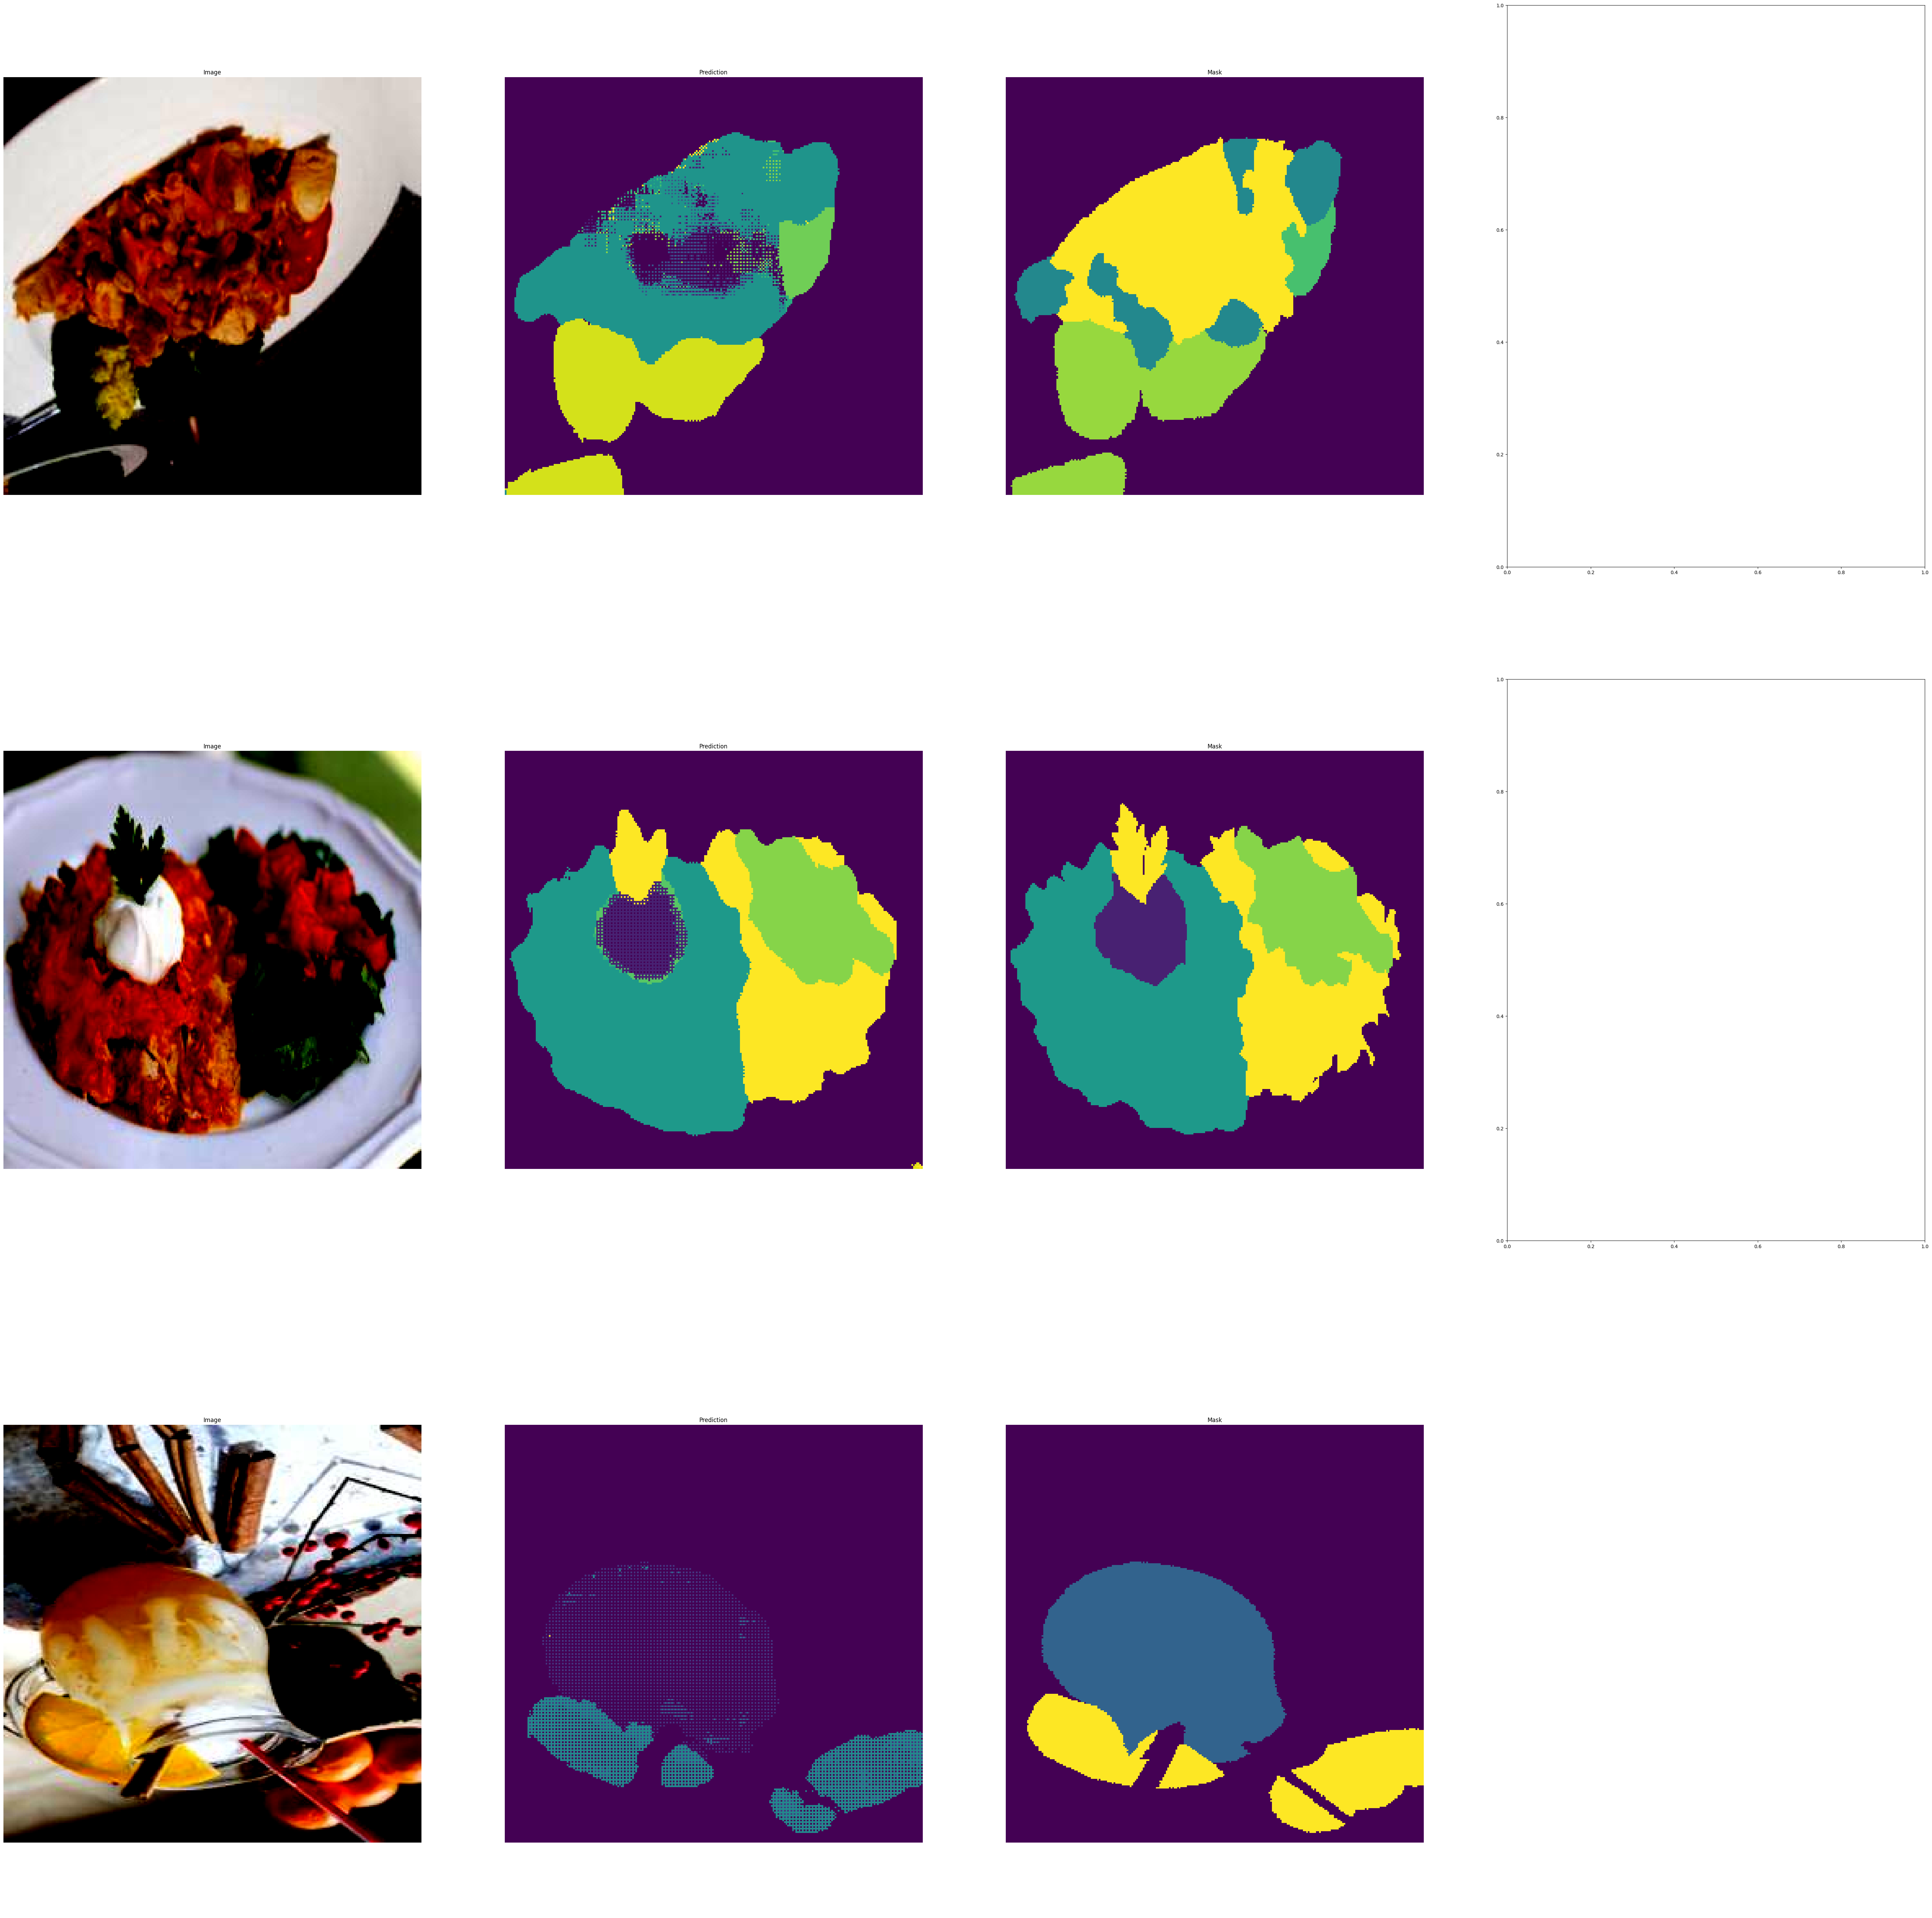

In [15]:


for x,y in test_batch:
    x = x.to(DEVICE)
    fig , ax =  plt.subplots(3, 4, figsize=(72, 72))
    softmax = nn.Softmax(dim=1)
    preds = torch.argmax(softmax(model(x)),axis=1).to('cpu')
    img1 = np.transpose(np.array(x[0,:,:,:].to('cpu')),(1,2,0))
    preds1 = np.array(preds[0,:,:])
    mask1 = np.array(y[0,:,:])
    img2 = np.transpose(np.array(x[1,:,:,:].to('cpu')),(1,2,0))
    preds2 = np.array(preds[1,:,:])
    mask2 = np.array(y[1,:,:])
    # print("Pred2", np.unique(preds2))
    img3 = np.transpose(np.array(x[2,:,:,:].to('cpu')),(1,2,0))
    preds3 = np.array(preds[2,:,:])
    mask3 = np.array(y[2,:,:])
    # print("Pred3", np.unique(preds3))
    ax[0,0].set_title('Image')
    ax[0,1].set_title('Prediction')
    ax[0,2].set_title('Mask')
    # ax[0,3].set_title('Overlay')
    ax[1,0].set_title('Image')
    ax[1,1].set_title('Prediction')
    ax[1,2].set_title('Mask')
    # ax[1,3].set_title('Overlay')
    ax[2,0].set_title('Image')
    ax[2,1].set_title('Prediction')
    ax[2,2].set_title('Mask')
    # ax[2,3].set_title('Overlay')
    ax[0][0].axis("off")
    ax[1][0].axis("off")
    ax[2][0].axis("off")
    ax[0][1].axis("off")
    ax[1][1].axis("off")
    ax[2][1].axis("off")
    ax[0][2].axis("off")
    ax[1][2].axis("off")
    ax[2][2].axis("off")
    ax[2][3].axis("off")
    ax[0][0].imshow(img1)
    ax[0][1].imshow(preds1)
    ax[0][2].imshow(mask1)
    # ax[0][3].imshow(color.label2rgb(mask1, img1, saturation=1, alpha=0.5, bg_color=None))

    ax[1][0].imshow(img2)
    ax[1][1].imshow(preds2)
    ax[1][2].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(preds3)
    ax[2][2].imshow(mask3)
    break